In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import autoencoder.helpers as helpers
from autoencoder.neuralnet import NeuralNetwork
from autoencoder.layers import (
  LinearLayer,
  SigmoidLayer,
  TanhLayer,
  ReluLayer,
  MSEOutputLayer
)

import tikhonov
from utils import avgn_attack, ssim

In [2]:
shape=(28, 28)

In [19]:
def compare_denoised_images(images_true, images_noisy, denoised_samples, num_samples=8, idx=0, shape=(28, 28)):
  images_true_ = images_true[idx:idx+num_samples]
  images_noisy_ = images_noisy[idx:idx+num_samples]
  denoised_samples_ =  denoised_samples[idx:idx+num_samples]
  print(denoised_samples_.shape)
  fig, axs = plt.subplots(3, num_samples, figsize=(30, 10))
  axs_ = axs.ravel()

  for i, (ts, ns, ds) in enumerate(zip(images_true_, images_noisy_, denoised_samples_)):
    axs_[i].axis('off')
    axs_[(num_samples) + i].axis('off')
    axs_[(2 * num_samples) + i].axis('off')
    axs_[i].imshow(ts.reshape(shape), cmap="gray")
    axs_[(num_samples) + i].imshow(ns.reshape(shape), cmap="gray")
    axs_[(2 * num_samples) + i].imshow(ds.reshape(shape), cmap="gray")

In [101]:
def compare_tikhonov_autoencoder_ssim(clean_images, noisy_images, tikhonov_images, autoencoder_images, idx=0, figsize=(12, 12), shape=(28, 28)):
  (clean_image, noisy_image, tikhonov_image, autoencoder_image) = \
    (clean_images[idx].reshape(shape),
     noisy_images[idx].reshape(shape),
     tikhonov_images[idx].reshape(shape),
     autoencoder_images[idx].reshape(shape))
 
  fig, axs = plt.subplots(2, 2, figsize=figsize, gridspec_kw={'hspace': 0.15, 'wspace': -0.125})
  axs_ = axs.ravel()

  imgs_info = [
    {'name': 'Чисте зображення', 'img': clean_image, 'ssim': ssim(clean_image, clean_image)},
    {'name': 'Пошкоджене зображення', 'img': noisy_image, 'ssim': ssim(clean_image, noisy_image)},
    {'name': 'Регуляризація Тіхонова', 'img': tikhonov_image, 'ssim': ssim(clean_image, tikhonov_image)},
    {'name': 'Автоенкодер', 'img': autoencoder_image, 'ssim': ssim(clean_image, autoencoder_image)},
  ]

  for ax, img_info in zip(axs_, imgs_info):
    ax.imshow(img_info['img'], 'gray')
    ax.axis('off')
    ax.set_title(f"{img_info['name']}\n SSIM: {np.round(img_info['ssim'], 3)}", fontsize=15)
  
  fig.savefig('images/denoising_methods_comparation.pdf')

In [29]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.reshape(-1, 28*28) / 255
X_test = X_test.reshape(-1, 28*28) / 255

In [36]:
X_train_noisy = np.array([avgn_attack(x, 0.5, 0) for x in X_train])
X_test_noisy = np.array([avgn_attack(x, 0.5, 0) for x in X_test])
X_test_denoised_tikhonov = tikhonov.tikhonov_denoise_images(X_test_noisy, 0.55, 100)

In [37]:
# compare_tikhonov_autoencoder_ssim(X_test, X_test_noisy, X_test_denoised_tikhonov, X_test_denoised_autoencoder, idx=12)

In [103]:
prefix = "denoising-awgn-05-100-iter-128-batch"
new_layers = helpers.load_model(prefix)
net = NeuralNetwork()
net.load_layers(new_layers)
X_test_denoised_autoencoder = net.forward_step(X_test_noisy)[-1]

(8, 784)


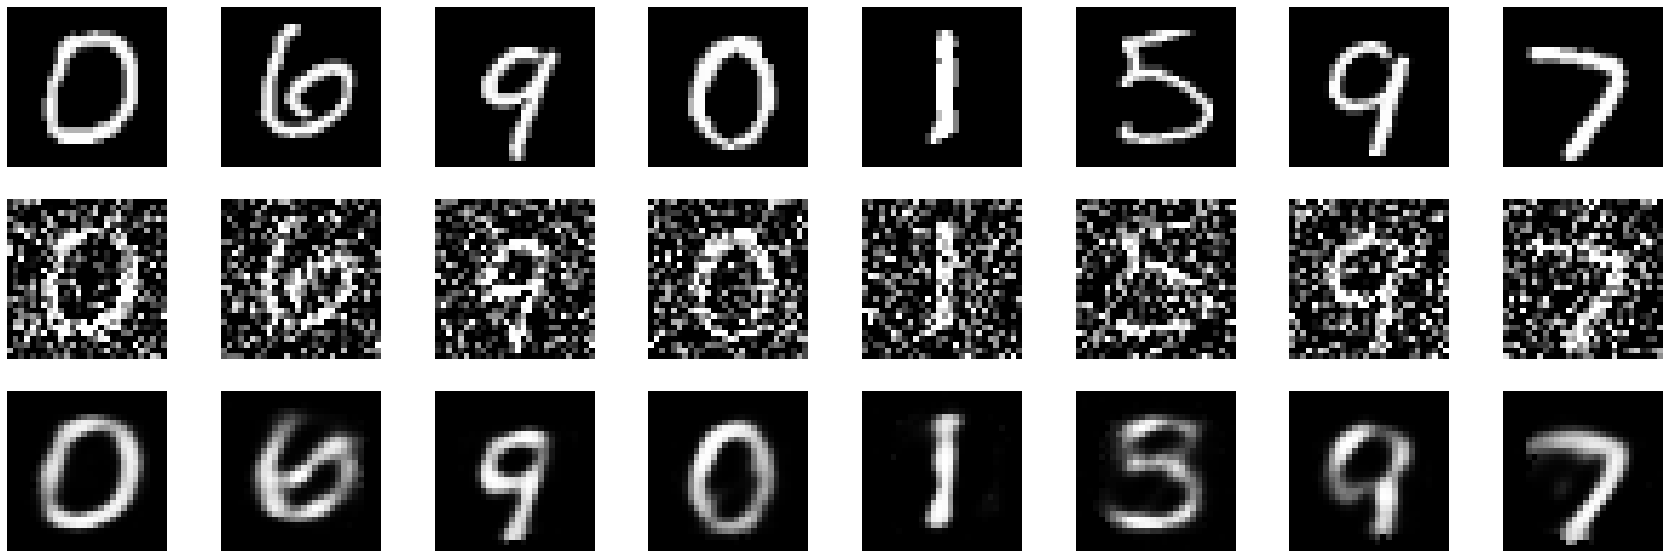

In [104]:
compare_denoised_images(X_test, X_test_noisy, X_test_denoised_autoencoder, idx=10)

In [105]:
X_test_denoised_tikhonov = tikhonov.tikhonov_denoise_images(X_test_noisy, 0.25, 100)

(8, 784)


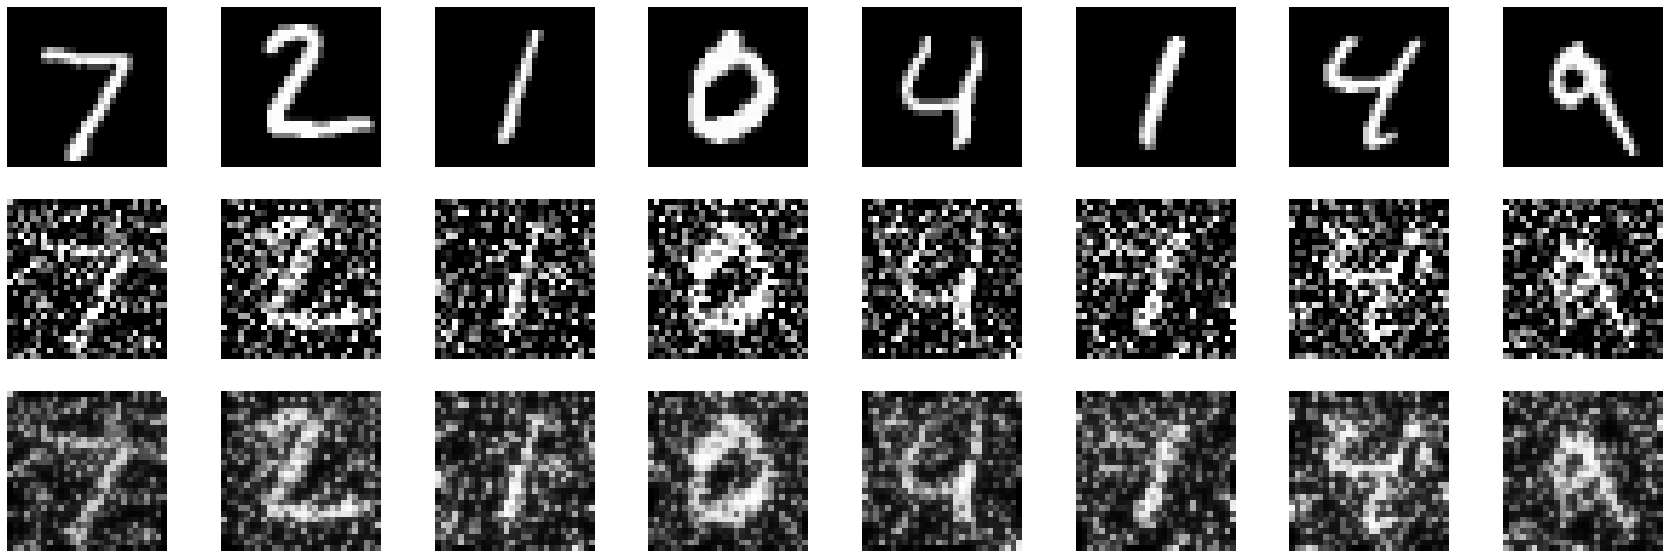

In [106]:
compare_denoised_images(X_test, X_test_noisy, X_test_denoised_tikhonov)

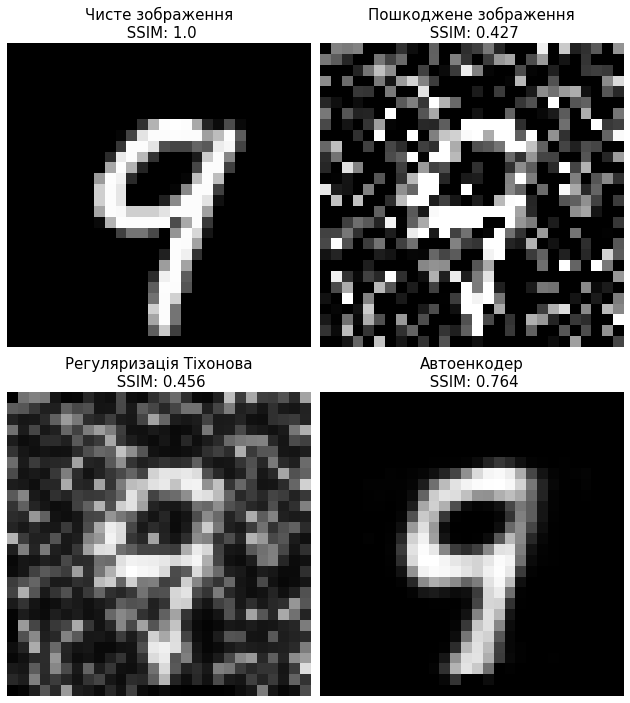

In [129]:
compare_tikhonov_autoencoder_ssim(X_test, X_test_noisy, X_test_denoised_tikhonov, X_test_denoised_autoencoder, idx=12)

In [82]:
# # Number of neurons in the first hidden-layer
# hidden_neurons_1 = 64

# # Number of neurons in the second hidden-layer
# hidden_neurons_2 = 32

# hidden_neurons_3 = 32

# # latent_neurons = 32

# # Define a list of layers
# net_layers = []

# net_layers.append(LinearLayer(X_train.shape[1], hidden_neurons_1))
# net_layers.append(ReluLayer())

# net_layers.append(LinearLayer(hidden_neurons_1, hidden_neurons_2))
# net_layers.append(ReluLayer())

# # net_layers.append(LinearLayer(hidden_neurons_2, hidden_neurons_3))
# # net_layers.append(ReluLayer())

# # net_layers.append(LinearLayer(hidden_neurons_2, hidden_neurons_3))
# # net_layers.append(TanhLayer())

# # net_layers.append(LinearLayer(hidden_neurons_3, hidden_neurons_2))
# # net_layers.append(TanhLayer())

# # net_layers.append(LinearLayer(hidden_neurons_2, hidden_neurons_1))
# # net_layers.append(TanhLayer())

# net_layers.append(LinearLayer(hidden_neurons_3, X_train.shape[1]))
# net_layers.append(SigmoidLayer())

# #net_layers.append(SoftmaxOutputLayer())
# net_layers.append(MSEOutputLayer())

# net = NeuralNetwork()

# # Tahh -> Sigmoid ~100

# net.fit(X_train_noisy, X_train, X_test_noisy, X_test, net_layers, 
#         max_iterations=30, batch_size=128, learning_rate=0.01, output_each_iter=1)

In [14]:
# fig, axs_costs = plt.subplots(1, 3, figsize=(15, 5))
# axs_costs_ = axs_costs.ravel()
# for i, costs in enumerate(
#   [net.train_costs, net.val_costs, net.batch_costs]):
#   axs_costs_[i].plot(costs)